# Visualize Word Embedding with Plotly

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense,LSTM,GRU,Embedding,Dropout,Flatten,GaussianNoise
from tensorflow.keras.callbacks import EarlyStopping,LambdaCallback
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.graph_objects as go
from pickle import dump,load
import os
%matplotlib inline

In [87]:
#CONSTANTS
EMBEDDING_DIM = 3
VALIDATION_SPLIT = 0.3
SAMPLE_SIZE = 0.9
MAX_SEQUENCE_LENGTH = 100
FILE_PATH = '../../6 - NPL files/yelp_training_set_review(with text_length and transformed)-new.csv'
GLOVE_DIR = '../../../Machine Learning documents/glove/'

In [88]:
data_file = pd.read_csv(FILE_PATH)
data_file = data_file[(data_file['stars'] == 1) | (data_file['stars'] == 5)].sample(frac=SAMPLE_SIZE).copy()
data_file = data_file[['stars', 'text_transformed']]

In [89]:
all_text = data_file['text_transformed'].values
all_text = all_text.astype('str')
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_text)
#dump(tokenizer,open('keras_lstm_tokenizer','wb'))
sequences = tokenizer.texts_to_sequences(all_text)
count_unique = len(tokenizer.word_counts)
pad_encoded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, truncating='post', padding='post')

In [90]:
X = np.array(pad_encoded)
y = pd.get_dummies(data_file['stars'], drop_first=True).values
# y = to_categorical(data_file['stars'], num_classes=5)
seq_len = X.shape[1]

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VALIDATION_SPLIT, random_state=42)
print(X_train.shape,X_test.shape)

(59036, 100) (25302, 100)


In [124]:
compare_model = {}
saved_weights = []

In [125]:
class NLP_training():
    def __init__(self, model_name, model):
        self.model = model
        self.model_name = model_name
        self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        # print(self.model.summary())
    def fit_plot(self, X_train, y_train, X_test, y_test, verbose, plot_bar=True):
        early_stop = EarlyStopping(monitor='loss', mode='min',patience=10)
        weight_callback = LambdaCallback(on_epoch_end=lambda batch,logs: 
                                              saved_weights.append(model.layers[0].get_weights()))
        history = self.model.fit(X_train,y_train,
                                 batch_size=128,
                                 epochs=100,
                                 verbose=verbose,
                                 validation_data=(X_test, y_test),
                                 callbacks=[early_stop,weight_callback]
                                 )
        #plot the results
        loss, accuracy = self.model.evaluate(X_test, y_test, verbose=0)
        print('Accuracy: %f' % (accuracy*100))
        compare_model[self.model_name] = accuracy*100
        plt.figure(figsize=(14,4))
        ax = plt.subplot(1,2,1)
        pd.DataFrame(history.history).plot(ax=ax)
        if plot_bar:
            ax = plt.subplot(1,2,2)
            pd.DataFrame(compare_model, index=['models']).plot(kind='bar', ax=ax, rot=0)
            plt.ylim([94.0,97.0])
            plt.legend(loc=(1,0.6))

In [126]:
def plot_embeded_text(model, tokenizer, saved_weights, X_features, y_results, num_display=50):
    
    index_star_map = {}
    for i,j in zip(X_features,y_results):
        for k in i:
            if k not in index_star_map.keys():
                index_star_map[k] = []
            index_star_map[k].append(j)
    for i,j in index_star_map.items():
        index_mean_rating = mean(j)
        index_star_map[i] = round(index_mean_rating )
    index_star_map[0] = 0

    
    X_1d = X.flatten()
    
    
    unique_index = sorted(np.unique(X_1d, return_index=True)[1])
    
    
    words_inorder = np.array(list(map(tokenizer.index_word.get,X_1d[unique_index])))
    ratings_inorder = np.array(list(map(index_star_map.get,X_1d[unique_index])))

    random_sample = np.random.randint(low=0,high=len(unique_index),size=num_display)
    
    
    used_sequences = saved_weights[0][0][X_1d[unique_index]]

    
    if used_sequences.shape[1] >= 3:
        fig = go.Figure()
        for weight in saved_weights:
            #print(words_inorder[random_sample])
            used_sequences = weight[0][X_1d[unique_index]]
            #words_inorder = words_inorder[random_sample]
            
            #ratings_inorder = ratings_inorder[random_sample]
            used_sequences = used_sequences[random_sample]
            
#             if used_sequences.shape[1] > 3:
#                 pca = PCA(n_components=3)
#                 embedding_weights = pca.fit_transform(used_sequences)

#                 df = pd.DataFrame(embedding_weights)
            df = pd.DataFrame(used_sequences)
            fig.add_trace(go.Scatter3d(x=df[0],y=df[1],z=df[2],
                                       mode='markers+text',
                                       marker=dict(color=ratings_inorder[random_sample],colorscale='Viridis'),
                                       text=words_inorder[random_sample]
                                       )
                         )
        fig.data[99].visible = True
        steps = []
        for i in range(len(fig.data)):
            step = dict(
                method="update",
                args=[{"visible": [False] * len(fig.data)},
                      {"title": "Slider switched to step: " + str(i)}],  # layout attribute
            )
            step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
            steps.append(step)

        sliders = [dict(
            active=0,
            currentvalue={"prefix": "Epoch: "},
            pad={"t": 50},
            steps=steps
        )]

        fig.update_layout(
            sliders=sliders
        )
        fig.show()
    
    
    
#     if used_sequences.shape[1] >= 3:
#         if used_sequences.shape[1] > 3:
#             pca = PCA(n_components=3)
#             embedding_weights = pca.fit_transform(used_sequences)
#         elif used_sequences.shape[1] == 3:
#             embedding_weights = used_sequences
#             pca = PCA(n_components=3)
#             embedding_weights = pca.fit_transform(used_sequences)
#         df = pd.DataFrame(embedding_weights)
#         fig = px.scatter_3d(df,x=0,y=1,z=2,
#                             color=ratings_inorder,text=words_inorder
#                            )
#         fig.show()
#     elif model.get_weights()[0].shape[1] == 2:
#         df = pd.DataFrame(used_sequences)
#         fig = px.scatter(data_frame=df,x=0,y=1,
#                          size=ratings_inorder,text=words_inorder
#                         )
#         fig.show()

### 1.Embedding layer: trainable

Accuracy: 95.775038


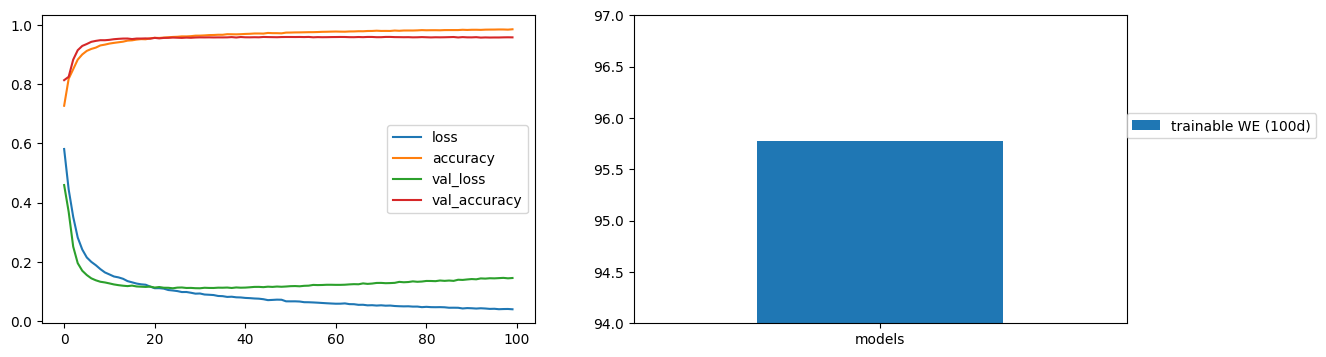

In [127]:
model = Sequential()
# the size of the vocabulary is len + 1, since 0 is also a word
model.add(Embedding(count_unique+1, output_dim=4, input_length=MAX_SEQUENCE_LENGTH)) 
model.add(GaussianNoise(1.0))
model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))

nlp = NLP_training('trainable WE (100d)', model)
nlp.fit_plot(X_train, y_train, X_test, y_test, verbose=0)

In [129]:
plot_embeded_text(model,tokenizer,saved_weights=saved_weights,X_features=X,y_results=data_file['stars'])

In [ ]:
go.Scatter3d()